### A simple fMRI analysis using SPM with nipype

Resources: 
     - https://miykael.github.io/nipype_tutorial/notebooks/introduction_showcase.html
     - https://pythonhosted.org/nipype/users/examples/fmri_spm_face.html

In [1]:
from nipype import Node, Workflow
import os
import nipype.interfaces.matlab as mlab

Failed to import duecredit due to No module named 'duecredit'


In [2]:
# Set the way matlab should be called -- TODO
mlab.MatlabCommand.set_default_matlab_cmd("/Applications/MATLAB_R2017a.app/bin/matlab -nodesktop -nosplash")
# If SPM is not in your MATLAB path you should add it here
mlab.MatlabCommand.set_default_paths(os.path.join(os.getcwd(), '..', '..', 'spm8'))

In [3]:
from nipype.interfaces.spm import Segment, SliceTiming, Realign, Coregister, Normalize, Smooth
from nipype.interfaces.fsl import ExtractROI

In [4]:
# Defaults

tr = 2.5;
ta = 2.5;

num_img_stab = 2;

num_slices = 30

# FIS_UNITS = 'secs';

# FIS_CONDITIONS{1} = struct(...
#     'sessName', 'se_fingerfootlips',...
#     'condnames', {'finger'},...
#     'onsets', {(10:90:430) - NUM_IMG_STAB.nBeg*TR},...
#     'duration',{15});

# FIS_CONTRASTS{1} = struct(...
#     'contrastName', 'cn_figer', ...
#     'name', 'Motor finger: activations', ...
#     'coninfo', 'co_finger', ...
#     'negative', true, ...
#     'nameNegative', 'Motor finger: deactivations',...
#     'sessrep', 'none');

# INFORMED_BASIS_SET = false;

# FIS_THRESHOLDS{1} = struct('threshdesc', 'none', 'thresh', 0.001);

# GU_CONTRASTS{1} = struct(...
#     'contrastName', 'cn_figer', ...
#     'name', 'Motor finger: group activations', ...
#     'coninfo', 'co_finger', ...
#     'negative', true, ...
#     'nameNegative', 'Motor finger: deactivations',...
#     'sessrep', 'none');

# GU_THRESHOLDS{1} = struct('threshdesc', 'FWE', 'thresh', 0.05);

In [5]:
ds114 = os.path.join(os.getcwd(), '..', 'data', 'ds000114_R2.0.1')

### anatomical MRI preprocessing

In [6]:
segment = Node(Segment(save_bias_corrected=True), name="segment")

### fMRI preprocessing

In [7]:
TR=tr
slicetiming = Node(SliceTiming(time_repetition=TR,
                             time_acquisition=TR - TR / float(num_slices),
                             num_slices = num_slices,
                             slice_order = list(range(0, num_slices, 2)) + list(range(1, num_slices, 2)), # TODO
                             ref_slice = int(num_slices / 2)), name="slicetiming")
realign = Node(Realign(), name = 'realign')
coreg = Node(Coregister(), name = 'coreg')
norm = Node(Normalize(), name = 'norm')
smooth = Node(Smooth(), name = 'smooth')

preproc = Workflow(name='preproc01')
preproc.base_dir = os.path.join('.')


In [16]:
len(list(range(0, num_slices, 2)) + list(range(1, num_slices, 2)))


30

In [8]:
# slicetiming.inputs.in_files = [one_fmri_file]
# segment.inputs.data = one_anat_file



In [9]:
# list of session identifiers
task_list = ['fingerfootlips']

In [10]:
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink

# list of subject identifiers
# subject_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
subject_list = ['01', '02']

# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('task_name', task_list)]

# Skip dummy scans
extract = Node(ExtractROI(t_min=num_img_stab, t_size=-1, output_type='NIFTI'),
               name="extract")

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = os.path.join('sub-{subject_id}', 'ses-test', 'anat', 'sub-{subject_id}_ses-test_t1w.nii.gz')
func_file = os.path.join('sub-{subject_id}', 'ses-test', 'func',
                'sub-{subject_id}_ses-test_task-{task_name}_bold.nii.gz')

templates = {'anat': anat_file,
             'func': func_file}
selectfiles = Node(SelectFiles(templates,
                               base_directory=ds114),
                   name="selectfiles")

181120-18:22:37,906 nipype.workflow INFO:
	 Generated workflow graph: ./preproc01/graph.png (graph2use=colored, simple_form=True).


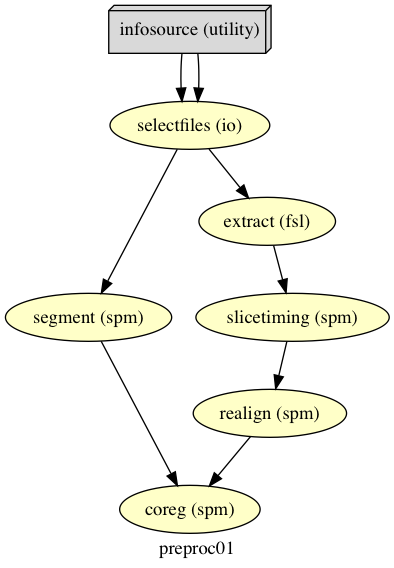

In [11]:
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('task_name', 'task_name')]),
                 (selectfiles, extract, [('func', 'in_file')]),
                 (extract, slicetiming, [('roi_file', 'in_files')]),
                 (slicetiming, realign, [('timecorrected_files', 'in_files')]),
                 (realign, coreg, [('mean_image', 'source')]),
                 (selectfiles, segment, [('anat', 'data')]),
                 (segment, coreg, [('bias_corrected_image', 'target')])])

preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=os.path.join(preproc.base_dir, 'preproc01', 'graph.png'))

In [12]:
preproc.run('MultiProc', plugin_args={'n_procs': 4})

181120-18:22:38,14 nipype.workflow INFO:
	 Workflow preproc01 settings: ['check', 'execution', 'logging', 'monitoring']
181120-18:22:38,54 nipype.workflow INFO:
	 Running in parallel.
181120-18:22:38,58 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 4/4.
181120-18:22:38,135 nipype.workflow INFO:
	 [Node] Setting-up "preproc01.selectfiles" in "/Users/camaumet/Softs/fmri_example_pipelines/scripts/preproc01/_subject_id_02_task_name_fingerfootlips/selectfiles".
181120-18:22:38,137 nipype.workflow INFO:
	 [Node] Setting-up "preproc01.selectfiles" in "/Users/camaumet/Softs/fmri_example_pipelines/scripts/preproc01/_subject_id_01_task_name_fingerfootlips/selectfiles".
181120-18:22:38,152 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")181120-18:22:38,154 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")

181120-18:22:38,167 nipype.workflow INF

181120-18:22:42,70 nipype.workflow ERROR:
	 Node segment.a0 failed to run on host medulla.irisa.fr.
181120-18:22:42,72 nipype.workflow ERROR:
	 Saving crash info to /Users/camaumet/Softs/fmri_example_pipelines/scripts/crash-20181120-182242-camaumet-segment.a0-28280393-8256-4a71-bb33-63a0dd3b4b35.pklz
Traceback (most recent call last):
  File "/anaconda3/envs/nipype/lib/python3.6/site-packages/nipype/pipeline/plugins/multiproc.py", line 69, in run_node
    result['result'] = node.run(updatehash=updatehash)
  File "/anaconda3/envs/nipype/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 408, in run
    cached, updated = self.is_cached()
  File "/anaconda3/envs/nipype/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 294, in is_cached
    hashed_inputs, hashvalue = self._get_hashval()
  File "/anaconda3/envs/nipype/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 488, in _get_hashval
    self._get_inputs()
  File "/anaconda3/envs/nipype/

181120-18:23:30,136 nipype.workflow ERROR:
	 Node slicetiming.a0 failed to run on host medulla.irisa.fr.
181120-18:23:30,139 nipype.workflow ERROR:
	 Saving crash info to /Users/camaumet/Softs/fmri_example_pipelines/scripts/crash-20181120-182330-camaumet-slicetiming.a0-33dbaa3b-7145-45e0-ba50-c449c2e78824.pklz
Traceback (most recent call last):
  File "/anaconda3/envs/nipype/lib/python3.6/site-packages/nipype/pipeline/plugins/multiproc.py", line 69, in run_node
    result['result'] = node.run(updatehash=updatehash)
  File "/anaconda3/envs/nipype/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 471, in run
    result = self._run_interface(execute=True)
  File "/anaconda3/envs/nipype/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 555, in _run_interface
    return self._run_command(execute)
  File "/anaconda3/envs/nipype/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 635, in _run_command
    result = self._interface.run(cwd=outdir)

RuntimeError: Workflow did not execute cleanly. Check log for details

%% Deal with zipped files

In [ ]:
one_fmri_file = os.path.join('/Users/camaumet/Softs/fmri_example_pipelines/data/ds000114_R2.0.1/', 'sub-01', 'ses-test', 'func', 'sub-01_ses-test_task-fingerfootlips_bold.nii')
one_anat_file = os.path.join('/Users/camaumet/Softs/fmri_example_pipelines/data/ds000114_R2.0.1/', 'sub-01', 'ses-test', 'anat', 'sub-01_ses-test_T1w.nii')

In [ ]:
one_fmri_file

In [ ]:
# Specify the location of the data downloaded from http://www.fil.ion.ucl.ac.uk/spm/data/face_rep/face_rep_SPM5.html
data_dir = os.path.abspath('spm_face_data')
# Specify the subject directories
subject_list = ['M03953']
# Map field names to individual subject runs.
info = dict(func=[['RawEPI', 'subject_id', 5, ["_%04d" % i for i in range(6, 357)]]],
            struct=[['Structural', 'subject_id', 7, '']])


In [ ]:
info

In [ ]:
from nipype.pipeline import Node, MapNode, Workflow
from nipype.interfaces.io import BIDSDataGrabber

ex2_BIDSDataGrabber = BIDSDataGrabber()
ex2_BIDSDataGrabber.inputs.base_dir = ds114
ex2_BIDSDataGrabber.inputs.subject = '10'
ex2_BIDSDataGrabber.inputs.output_query = {'T1w': dict(modality='anat')}

ex2_res = ex2_BIDSDataGrabber.run()
ex2_res.outputs

In [ ]:
os.getcwd()

In [ ]:
from bids.layout import BIDSLayout
layout = BIDSLayout("/data/ds000114/")